In [284]:
from torch import nn
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

Stopwords - это часто используемое слово (“the”, “a”, “an” или “in”), которое поисковая система запрограммирована игнорировать как при индексации записей для поиска, так и при их извлечении в результате поискового запроса.

In [285]:
tqdm.pandas()
nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

BATCH_SIZE = 128

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(DEVICE)

mps


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linearlys/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/linearlys/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [286]:
data = pd.read_csv("./data/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [287]:
def transform_label(label):
    return 1 if label == "positive" else 0


def rm_link(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)


def rm_punctuation(text):
    return re.sub(
        r"[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]", " ", text
    )


def rm_html(text):
    return re.sub(r"<[^>]+>", "", text)


def space_bt_punct(text):
    pattern = r"([.,!?-])"
    s = re.sub(pattern, r" \1 ", text)
    s = re.sub(r"\s{2,}", " ", s)
    return s


def rm_number(text):
    return re.sub(r"\d+", "", text)


def rm_whitespaces(text):
    return re.sub(r" +", " ", text)


def rm_nonascii(text):
    return re.sub(r"[^\x00-\x7f]", r"", text)


def rm_emoji(text):
    emojis = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emojis.sub(r"", text)


def spell_correction(text):
    return re.sub(r"(.)\1+", r"\1\1", text)


def clean_pipeline(text):
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punctuation(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected


def tokenize(text):
    return word_tokenize(text)


def rm_stopwords(text):
    return [i for i in text if i not in stopwords]


def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    return rm_stopwords(lemmas)


def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return " ".join(lemmas)

In [288]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 1821567.11it/s]


,review,sentiment,clean,processed,label
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production . The filming te...,A wonderful little production . The filming te...,1
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...,1
3,Basically there's a family where a little boy ...,negative,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...,1


In [289]:
data[['processed', 'label']].to_csv('./imdb_processed.csv', index=False, header=True)

In [290]:
data = pd.read_csv("./imdb_processed.csv")

In [291]:
reviews = data.processed.values
words = ' '.join(reviews)
words = words.split()
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
ENUM_VOCAB = {w: i + 1 for i, w in enumerate(vocab)}

In [292]:
def padding_(sentences, seq_len=256):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for i, review in enumerate(sentences):
            features[i, :len(review)] = np.array(review)[:seq_len]
    return features

def compress(_x):
    final_list_train = []
    for sent in _x:
        for word in sent.lower().split():
            if word in ENUM_VOCAB.keys():
                final_list_train.append(ENUM_VOCAB[word])
    
    return np.array(final_list_train)

In [293]:
test_size = 0.3
validation_size = 0.5

values = data['processed'].progress_apply(compress)
values = padding_(values)

x_train, x_remain, y_train, y_remain = train_test_split(
    values,
    data["label"].values,
    test_size=test_size,
    shuffle=True,
    random_state=42,
)

x_validation, x_test, y_validation, y_test = train_test_split(
    x_remain, y_remain, test_size=validation_size
)

100%|██████████| 50000/50000 [00:06<00:00, 7862.45it/s]


In [294]:
train_set = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
val_set = TensorDataset(torch.from_numpy(x_validation), torch.from_numpy(y_validation))
test_set = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_set, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [295]:
for images, labels in train_loader:
    print("Batch dimensions:", images.shape)
    print("Label dimensions:", labels.shape)
    break

Batch dimensions: torch.Size([128, 256])
Label dimensions: torch.Size([128])


Embedding — это техника, используемая для преобразования категориальных данных, таких как слова, идентификаторы пользователей или элементов, в вектора вещественных чисел. Эти векторные представления позволяют нейронным сетям эффективно работать с категориальными данными, улавливая и используя сложные связи между элементами категорий. 

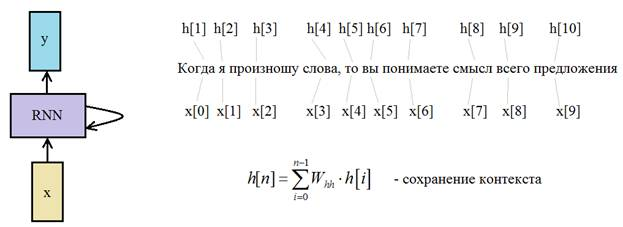

In [297]:
class RNNModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        output_size,
        hidden_size=128,
        embedding_size=400,
        n_layers=2,
        dropout = 0.2
    ):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ = self.rnn(x)
        o = o[:, -1, :]
        o = self.fc(o)
        return o

In [298]:
class StackedRNNModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        output_size,
        hidden_size=128,
        embedding_size=400,
        n_layers=2,
        dropout=0.2,
    ):
        super(StackedRNNModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn1 = nn.RNN(embedding_size, hidden_size, n_layers, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o1, _ = self.rnn1(x)
        o2, _ = self.rnn2(o1)
        o = o2[:, -1, :]
        o = self.fc(o)
        return o

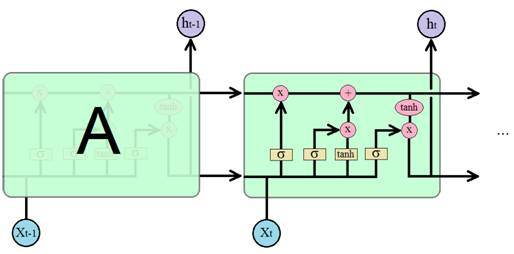
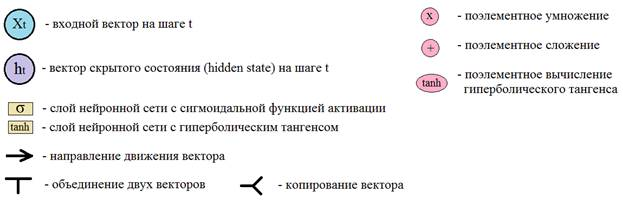

In [296]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        output_size,
        hidden_size=128,
        embedding_size=400,
        n_layers=2,
        dropout=0.2,
    ):
        super(LSTMModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(
            embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ = self.lstm(x)
        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)

        return o

In [340]:
def train(model, optim, criterion, epochs, history):
    print_every = 1
    es_limit = 3
    grad_clip = 5
    epochloop = tqdm(range(epochs), position=0, desc="Training", leave=True)

    es_trigger = 0
    val_loss_min = torch.inf

    for e in epochloop:
        model.train()

        train_loss = 0
        train_acc = 0

        for id, (feature, target) in enumerate(train_loader):
            epochloop.set_postfix_str(f"Training batch {id}/{len(train_loader)}")
            feature, target = feature.to(DEVICE), target.to(DEVICE)

            optim.zero_grad()

            out = model(feature)

            predicted = torch.tensor(
                [1 if i == True else 0 for i in out > 0.5], device=DEVICE
            )
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            train_acc += acc.item()

            loss = criterion(out.squeeze(), target.float())
            train_loss += loss.item()
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optim.step()

            del feature, target, predicted

        history["train_loss"].append(train_loss / len(train_loader))
        history["train_acc"].append(train_acc / len(train_loader))

        model.eval()

        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for id, (feature, target) in enumerate(val_loader):
                epochloop.set_postfix_str(f"Validation batch {id}/{len(val_loader)}")
                feature, target = feature.to(DEVICE), target.to(DEVICE)
                out = model(feature)
                predicted = torch.tensor(
                    [1 if i == True else 0 for i in out > 0.5], device=DEVICE
                )
                equals = predicted == target
                acc = torch.mean(equals.type(torch.FloatTensor))
                val_acc += acc.item()

                loss = criterion(out.squeeze(), target.float())
                val_loss += loss.item()

                del feature, target, predicted

            history["val_loss"].append(val_loss / len(val_loader))
            history["val_acc"].append(val_acc / len(val_loader))

        model.train()

        epochloop.set_postfix_str(
            f"Val Loss: {val_loss / len(val_loader):.3f} | Val Acc: {val_acc / len(val_loader):.3f}"
        )

        if (e + 1) % print_every == 0:
            epochloop.write(
                f"Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_loader):.3f} | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(val_loader):.3f}"
            )
            epochloop.update()

        if val_loss / len(val_loader) <= val_loss_min:
            torch.save(model.state_dict(), "./sentiment_lstm.pt")
            val_loss_min = val_loss / len(val_loader)
            es_trigger = 0
        else:
            epochloop.write(
                f"[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(val_loader):.3f})"
            )
            es_trigger += 1

        if es_trigger >= es_limit:
            epochloop.write(f"Early stopped at Epoch-{e+1}")
            history["epochs"] = e + 1
            break

In [341]:
def test_model(model, criterion):

    model.eval()

    test_loss = 0
    test_acc = 0

    all_target = []
    all_predicted = []

    testloop = tqdm(test_loader, leave=True, desc="Inference")
    with torch.no_grad():
        for feature, target in testloop:
            feature, target = feature.to(DEVICE), target.to(DEVICE)

            out = model(feature)

            predicted = torch.tensor(
                [1 if i == True else 0 for i in out > 0.5], device=DEVICE
            )
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            test_acc += acc.item()

            loss = criterion(out.squeeze(), target.float())
            test_loss += loss.item()

            all_target.extend(target.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

        print(
            f"Accuracy: {test_acc/len(test_loader):.4f}, Loss: {test_loss/len(test_loader):.4f}"
        )

In [342]:
def plot_loss(history):
    plt.figure(figsize=(6, 8))
    plt.plot(range(history['epochs']), history['train_loss'], label="Train Loss")
    plt.plot(range(history['epochs']), history['val_loss'], label="Val Loss")
    plt.legend()
    plt.show()

In [343]:
def plot_acc(history):
    plt.figure(figsize=(6, 8))
    plt.plot(range(history['epochs']), history['train_acc'], label="Train Acc")
    plt.plot(range(history['epochs']), history['val_acc'], label="Val Acc")
    plt.legend()
    plt.show()

RNNModel(
  (embedding): Embedding(121300, 256)
  (rnn): RNN(256, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
BCELoss()


Training:  20%|██        | 2/10 [01:33<05:09, 38.71s/it, Training batch 0/274]            

Epoch 1/10 | Train Loss: 1.871 Train Acc: 0.494 | Val Loss: 0.695 Val Acc: 0.489


Training:  30%|███       | 3/10 [03:07<07:26, 63.80s/it, Training batch 0/274]            

Epoch 2/10 | Train Loss: 0.709 Train Acc: 0.500 | Val Loss: 0.703 Val Acc: 0.489
[WARNING] Validation loss did not improved (0.695 --> 0.703)


Training:  50%|█████     | 5/10 [04:40<06:16, 75.34s/it, Training batch 0/274]            

Epoch 3/10 | Train Loss: 0.706 Train Acc: 0.501 | Val Loss: 0.702 Val Acc: 0.489
[WARNING] Validation loss did not improved (0.695 --> 0.702)


Training:  60%|██████    | 6/10 [06:14<04:00, 60.19s/it, Val Loss: 0.695 | Val Acc: 0.488]

Epoch 4/10 | Train Loss: 0.710 Train Acc: 0.500 | Val Loss: 0.695 Val Acc: 0.488


Training:  80%|████████  | 8/10 [07:49<01:40, 50.10s/it, Val Loss: 0.694 | Val Acc: 0.505]

Epoch 5/10 | Train Loss: 0.713 Train Acc: 0.501 | Val Loss: 0.694 Val Acc: 0.505


Training:  90%|█████████ | 9/10 [09:25<01:03, 63.26s/it, Training batch 0/274]            

Epoch 6/10 | Train Loss: 0.711 Train Acc: 0.507 | Val Loss: 0.697 Val Acc: 0.512
[WARNING] Validation loss did not improved (0.694 --> 0.697)


Training: 100%|██████████| 10/10 [11:00<00:00, 72.53s/it, Training batch 0/274]            

Epoch 7/10 | Train Loss: 0.705 Train Acc: 0.497 | Val Loss: 0.702 Val Acc: 0.487
[WARNING] Validation loss did not improved (0.694 --> 0.702)


Training:  70%|███████   | 7/10 [12:34<05:23, 107.82s/it, Val Loss: 0.770 | Val Acc: 0.487]


Epoch 8/10 | Train Loss: 2.979 Train Acc: 0.499 | Val Loss: 0.770 Val Acc: 0.487
[WARNING] Validation loss did not improved (0.694 --> 0.770)
Early stopped at Epoch-8


Inference: 100%|██████████| 59/59 [00:06<00:00,  9.34it/s]

Accuracy: 0.4953, Loss: 0.7637


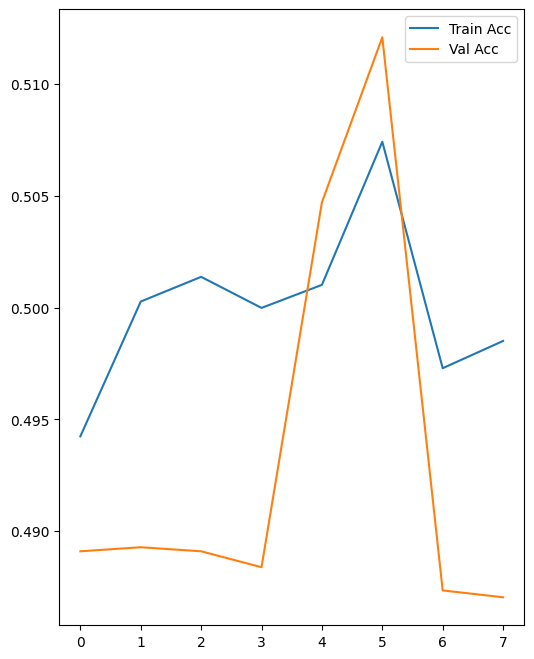

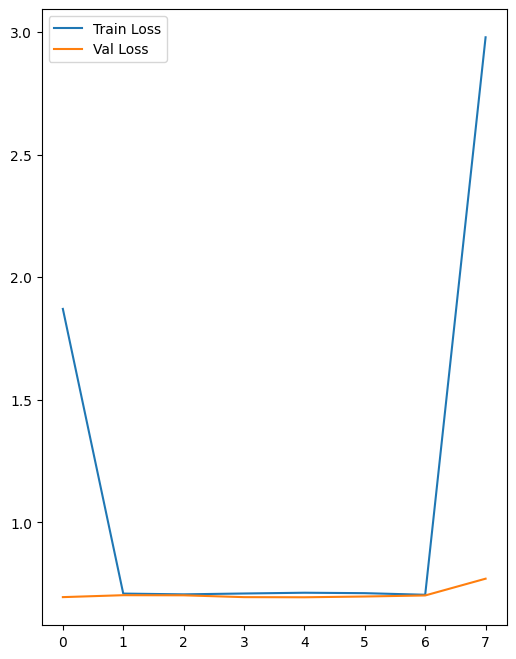

CrossEntropyLoss()


Training:  20%|██        | 2/10 [01:39<05:26, 40.83s/it, Training batch 0/274]              

Epoch 1/10 | Train Loss: 308.745 Train Acc: 0.503 | Val Loss: 314.899 Val Acc: 0.489


Training:  30%|███       | 3/10 [03:26<08:17, 71.07s/it, Training batch 0/274]              

Epoch 2/10 | Train Loss: 308.710 Train Acc: 0.503 | Val Loss: 315.127 Val Acc: 0.489
[WARNING] Validation loss did not improved (314.899 --> 315.127)


Training:  50%|█████     | 5/10 [04:59<06:38, 79.73s/it, Training batch 0/274]              

Epoch 3/10 | Train Loss: 308.958 Train Acc: 0.504 | Val Loss: 315.982 Val Acc: 0.505
[WARNING] Validation loss did not improved (314.899 --> 315.982)


Training:  30%|███       | 3/10 [06:32<15:15, 130.76s/it, Val Loss: 315.093 | Val Acc: 0.497]


Epoch 4/10 | Train Loss: 309.085 Train Acc: 0.504 | Val Loss: 315.093 Val Acc: 0.497
[WARNING] Validation loss did not improved (314.899 --> 315.093)
Early stopped at Epoch-4


Inference: 100%|██████████| 59/59 [00:06<00:00,  9.30it/s]

Accuracy: 0.5035, Loss: 308.7899


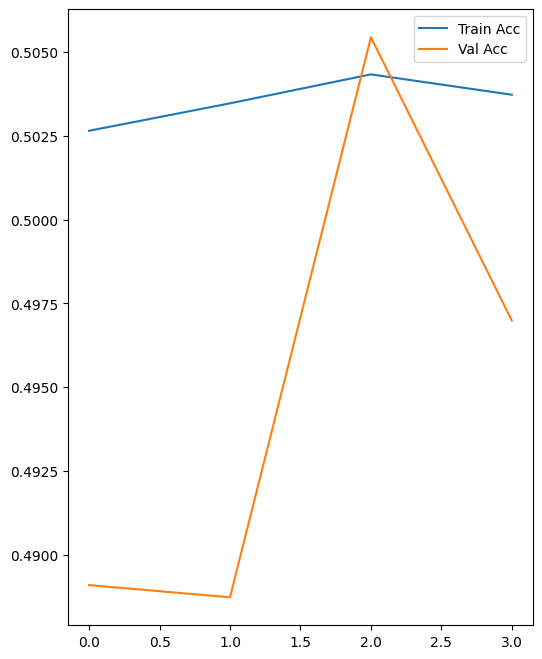

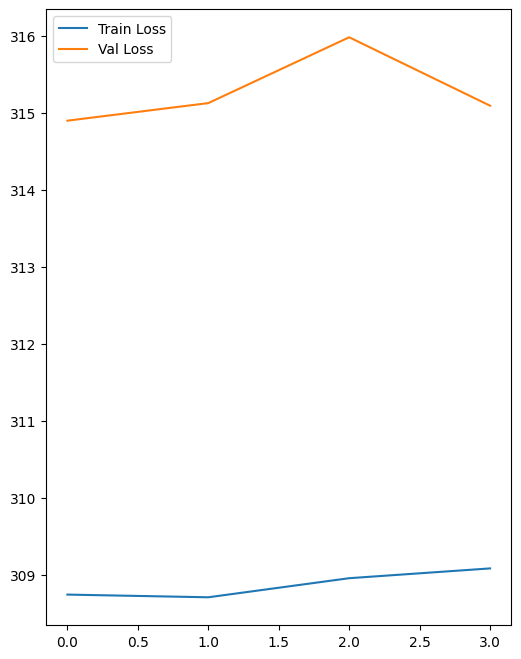

StackedRNNModel(
  (embedding): Embedding(121300, 256)
  (rnn1): RNN(256, 512, num_layers=2, batch_first=True)
  (rnn2): RNN(512, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)
BCELoss()


Training:  10%|█         | 1/10 [02:45<24:53, 165.98s/it, Val Loss: 0.703 | Val Acc: 0.489]

Epoch 1/10 | Train Loss: 1.853 Train Acc: 0.498 | Val Loss: 0.703 Val Acc: 0.489


Training:  30%|███       | 3/10 [05:30<13:07, 112.45s/it, Val Loss: 0.695 | Val Acc: 0.489]

Epoch 2/10 | Train Loss: 0.712 Train Acc: 0.497 | Val Loss: 0.695 Val Acc: 0.489


Training:  50%|█████     | 5/10 [08:16<11:06, 133.20s/it, Training batch 0/274]            

Epoch 3/10 | Train Loss: 0.715 Train Acc: 0.494 | Val Loss: 0.714 Val Acc: 0.511
[WARNING] Validation loss did not improved (0.695 --> 0.714)


Training:  60%|██████    | 6/10 [11:02<07:06, 106.60s/it, Training batch 0/274]            

Epoch 4/10 | Train Loss: 8.370 Train Acc: 0.501 | Val Loss: 1.295 Val Acc: 0.489
[WARNING] Validation loss did not improved (0.695 --> 1.295)


Training:  40%|████      | 4/10 [13:48<20:43, 207.20s/it, Val Loss: 0.726 | Val Acc: 0.514]


Epoch 5/10 | Train Loss: 0.841 Train Acc: 0.504 | Val Loss: 0.726 Val Acc: 0.514
[WARNING] Validation loss did not improved (0.695 --> 0.726)
Early stopped at Epoch-5


Inference: 100%|██████████| 59/59 [00:10<00:00,  5.54it/s]


Accuracy: 0.5032, Loss: 0.7314


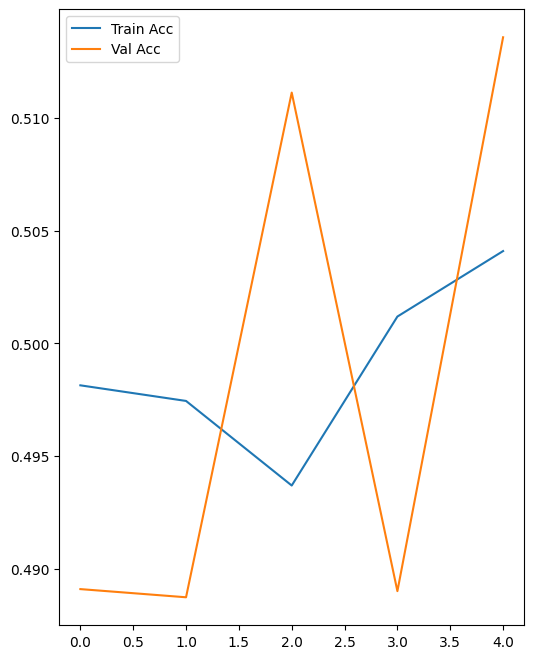

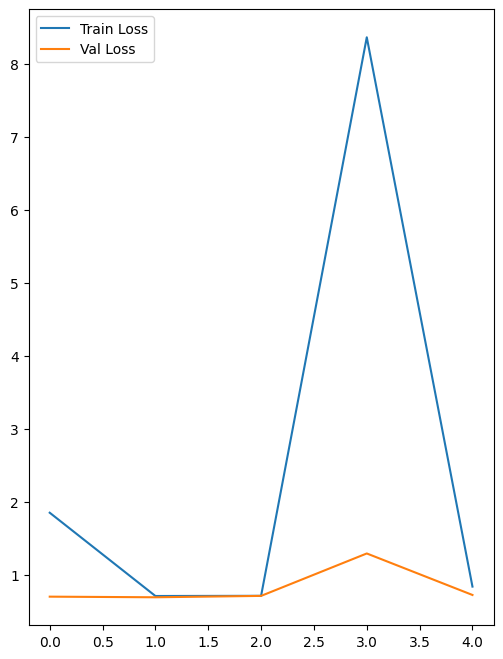

CrossEntropyLoss()


Training:  20%|██        | 2/10 [05:31<18:11, 136.47s/it, Val Loss: 314.868 | Val Acc: 0.489]

Epoch 1/10 | Train Loss: 308.526 Train Acc: 0.501 | Val Loss: 314.868 Val Acc: 0.489


Training:  30%|███       | 3/10 [1:16:49<3:56:33, 2027.70s/it, Training batch 0/274]              

Epoch 2/10 | Train Loss: 308.709 Train Acc: 0.499 | Val Loss: 315.304 Val Acc: 0.512
[WARNING] Validation loss did not improved (314.868 --> 315.304)


Training:  50%|█████     | 5/10 [1:19:37<1:47:46, 1293.30s/it, Training batch 0/274]              

Epoch 3/10 | Train Loss: 308.790 Train Acc: 0.498 | Val Loss: 315.076 Val Acc: 0.512
[WARNING] Validation loss did not improved (314.868 --> 315.076)


Training:  30%|███       | 3/10 [1:22:21<3:12:11, 1647.32s/it, Val Loss: 315.036 | Val Acc: 0.513]


Epoch 4/10 | Train Loss: 308.453 Train Acc: 0.500 | Val Loss: 315.036 Val Acc: 0.513
[WARNING] Validation loss did not improved (314.868 --> 315.036)
Early stopped at Epoch-4


Inference: 100%|██████████| 59/59 [00:10<00:00,  5.61it/s]


Accuracy: 0.5036, Loss: 308.6964


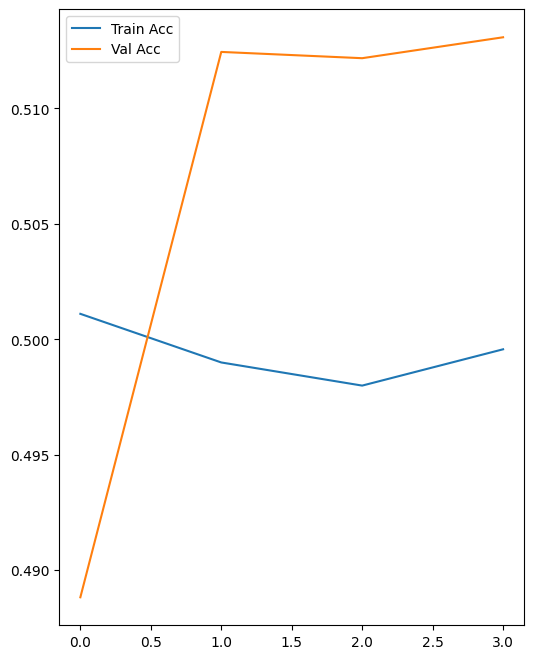

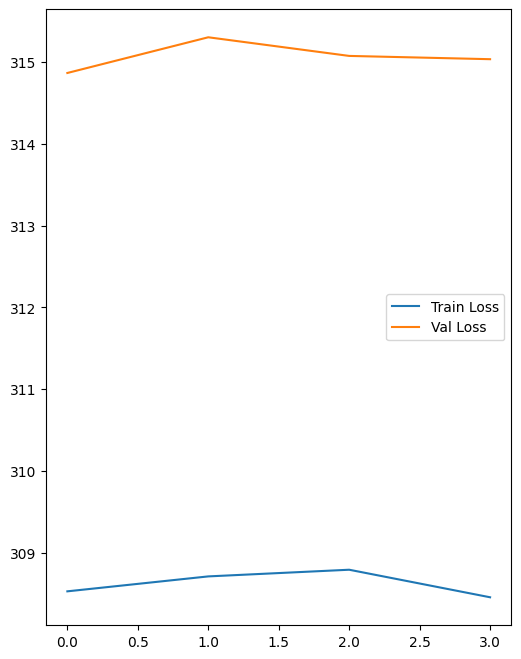

LSTMModel(
  (embedding): Embedding(121300, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
BCELoss()


Training:  20%|██        | 2/10 [01:57<06:25, 48.24s/it, Training batch 0/274]             

Epoch 1/10 | Train Loss: 0.695 Train Acc: 0.501 | Val Loss: 0.694 Val Acc: 0.489


Training:  30%|███       | 3/10 [03:53<09:15, 79.32s/it, Training batch 0/274]            

Epoch 2/10 | Train Loss: 0.689 Train Acc: 0.536 | Val Loss: 0.679 Val Acc: 0.584


Training:  50%|█████     | 5/10 [05:51<05:02, 60.55s/it, Training batch 0/274]            

Epoch 3/10 | Train Loss: 0.670 Train Acc: 0.594 | Val Loss: 0.665 Val Acc: 0.600


Training:  60%|██████    | 6/10 [07:48<05:18, 79.71s/it, Val Loss: 0.617 | Val Acc: 0.670]

Epoch 4/10 | Train Loss: 0.634 Train Acc: 0.645 | Val Loss: 0.617 Val Acc: 0.670


Training:  70%|███████   | 7/10 [09:46<04:36, 92.30s/it, Training batch 0/274]            

Epoch 5/10 | Train Loss: 0.590 Train Acc: 0.687 | Val Loss: 0.556 Val Acc: 0.712


Training:  90%|█████████ | 9/10 [11:45<01:09, 69.27s/it, Training batch 0/274]             

Epoch 6/10 | Train Loss: 0.551 Train Acc: 0.716 | Val Loss: 0.539 Val Acc: 0.724


Training: 100%|██████████| 10/10 [13:41<00:00, 83.70s/it, Val Loss: 0.514 | Val Acc: 0.747]

Epoch 7/10 | Train Loss: 0.509 Train Acc: 0.747 | Val Loss: 0.514 Val Acc: 0.747


Training: 11it [15:38, 93.90s/it, Training batch 0/274]                                    

Epoch 8/10 | Train Loss: 0.482 Train Acc: 0.765 | Val Loss: 0.496 Val Acc: 0.762


Training: 12it [17:34, 100.48s/it, Training batch 0/274]            

Epoch 9/10 | Train Loss: 0.456 Train Acc: 0.782 | Val Loss: 0.492 Val Acc: 0.766


Training: 100%|██████████| 10/10 [19:29<00:00, 116.95s/it, Val Loss: 0.508 | Val Acc: 0.759]


Epoch 10/10 | Train Loss: 0.429 Train Acc: 0.799 | Val Loss: 0.508 Val Acc: 0.759
[WARNING] Validation loss did not improved (0.492 --> 0.508)


Inference: 100%|██████████| 59/59 [00:08<00:00,  7.03it/s]


Accuracy: 0.7527, Loss: 0.5170


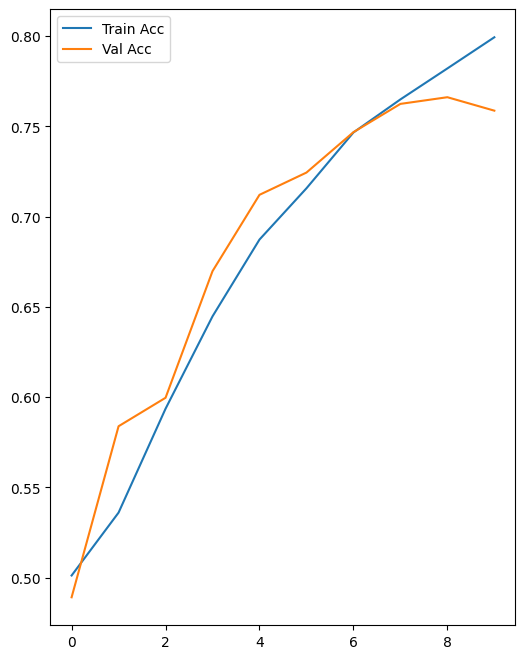

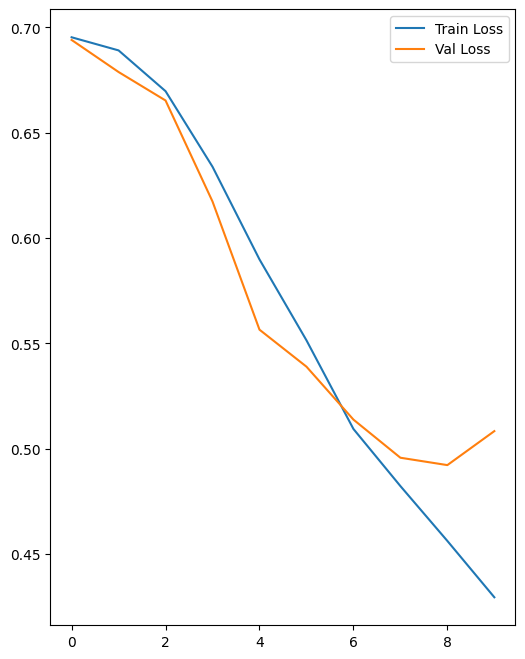

CrossEntropyLoss()


Training:  20%|██        | 2/10 [01:56<06:24, 48.03s/it, Training batch 0/274]               

Epoch 1/10 | Train Loss: 295.298 Train Acc: 0.811 | Val Loss: 304.617 Val Acc: 0.767


Training:  30%|███       | 3/10 [03:52<09:11, 78.84s/it, Training batch 1/274]              

Epoch 2/10 | Train Loss: 294.338 Train Acc: 0.828 | Val Loss: 304.875 Val Acc: 0.767
[WARNING] Validation loss did not improved (304.617 --> 304.875)


Training:  50%|█████     | 5/10 [05:48<07:47, 93.44s/it, Training batch 1/274]              

Epoch 3/10 | Train Loss: 293.561 Train Acc: 0.841 | Val Loss: 304.729 Val Acc: 0.771
[WARNING] Validation loss did not improved (304.617 --> 304.729)


Training:  30%|███       | 3/10 [07:43<18:01, 154.46s/it, Val Loss: 304.988 | Val Acc: 0.770]


Epoch 4/10 | Train Loss: 293.006 Train Acc: 0.850 | Val Loss: 304.988 Val Acc: 0.770
[WARNING] Validation loss did not improved (304.617 --> 304.988)
Early stopped at Epoch-4


Inference: 100%|██████████| 59/59 [00:08<00:00,  7.24it/s]


Accuracy: 0.7608, Loss: 298.7286


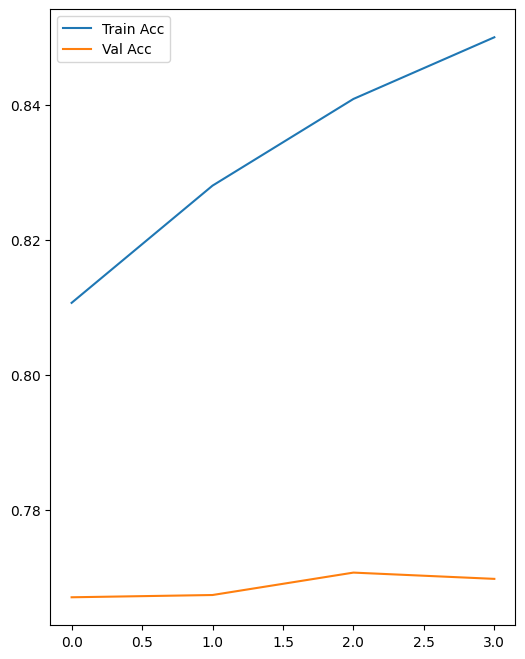

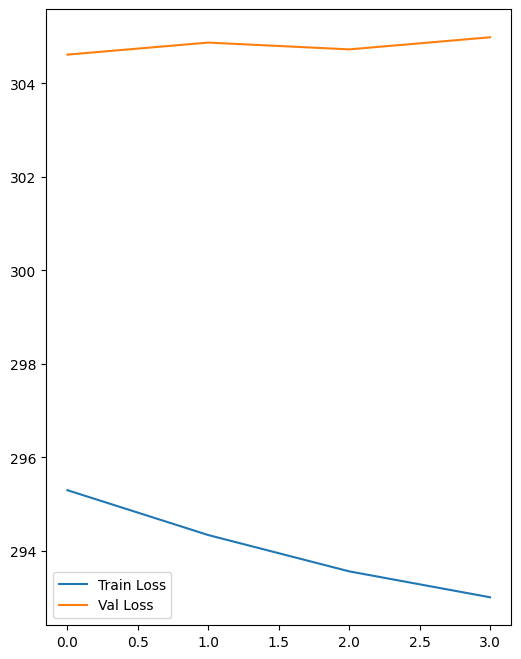

In [344]:
def train_models():
    output_size = 1
    embedding_size = 256
    hidden_size = 512
    n_layers = 2
    dropout = 0.25
    
    epochs = 10
    lr = 0.001
    models = (RNNModel, StackedRNNModel, LSTMModel)
    criterions = (nn.BCELoss(), nn.CrossEntropyLoss())
    for model in models:
        model = model(
            len(vocab), output_size, hidden_size, embedding_size, n_layers, dropout
        )
        model.to(DEVICE)
        print(model)
        for criterion in criterions:
            print(criterion)
            optim = torch.optim.Adam(model.parameters(), lr=lr)
            history = {
                "train_loss": [],
                "train_acc": [],
                "val_loss": [],
                "val_acc": [],
                "epochs": epochs,
            }
            train(model, optim, criterion, epochs, history)
            test_model(model, criterion)
            plot_acc(history)
            plot_loss(history)


train_models()